# Project: Diabetes classification using machine learning

The goal of this project is to classify whether a patient has diabetes based on specific health
metrics. We are expected to analyze the dataset, choose appropriate preprocessing
steps, apply classification models, and evaluate their performance.

The dataset used for this project is the Pima Indians Diabetes Dataset. It can be found on [Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database).

We will start by exploring the data using feature distributions and correlation matrix's. Doing so will grant us with 
a better understanding of the data. 
The data exploration will also consist of dealing with missing or abnormal entries by either replacing them with suitable values or 
just removing them from the dataset.

After that, we will build different predictive models using the suitable python libraries. The goal will be to optimize each one of them 
by tuning the respective hyperparameters.

Finally, we will select the appropriate data features for evaluation by applying the backward selection technique.

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from keras.src.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from sklearn.ensemble import RandomForestClassifier 

## Data exploration

First, we load the dataset.

In [24]:
df = pd.read_csv('data/diabetes.csv')

print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


Outcome
0    500
1    268
Name: count, dtype: int64


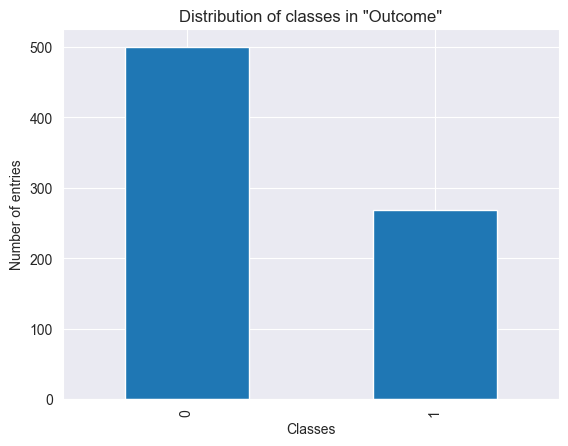

In [25]:
distribution_classes = df['Outcome'].value_counts()
print(distribution_classes)

distribution_classes.plot(kind='bar')
plt.title('Distribution of classes in "Outcome"')
plt.xlabel('Classes')
plt.ylabel('Number of entries')
plt.show()

We can notice that there are nearly twice as many non-diabetic people as diabetic people in the dataset, which means that the data is not well-balanced.

Let's visualize the average value of each feature for each outcome. This will give us an idea of the features that greatly differ between diabetic and non-diabetic people. We can then make first assumptions on the most important features for prediction.

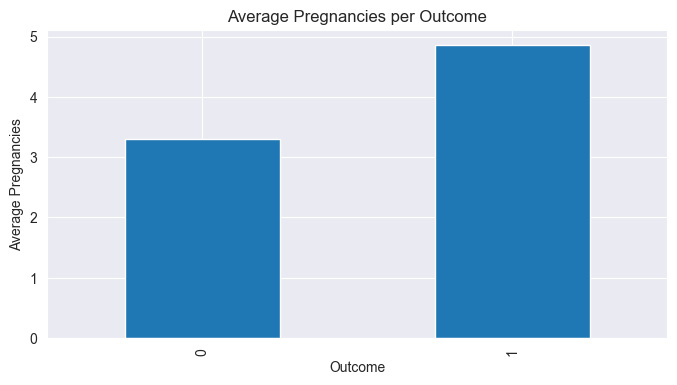

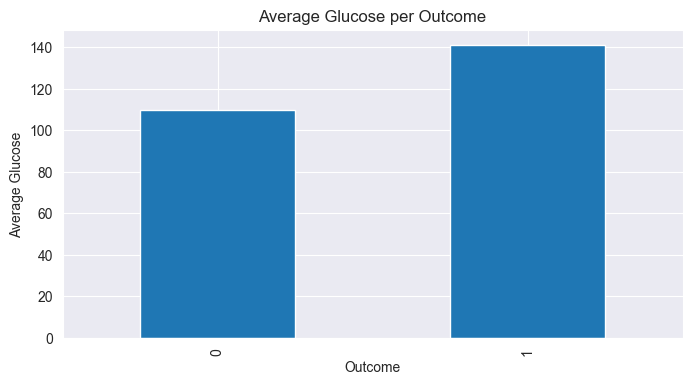

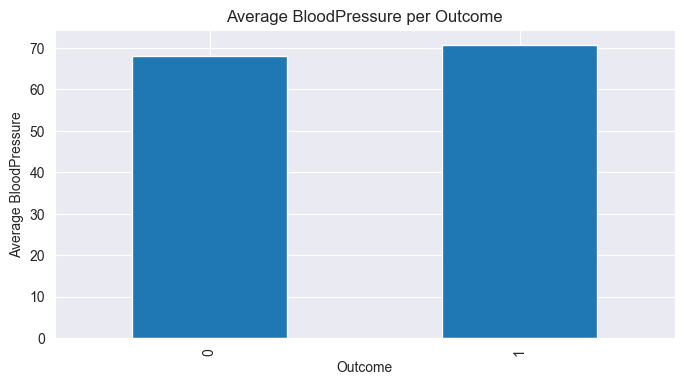

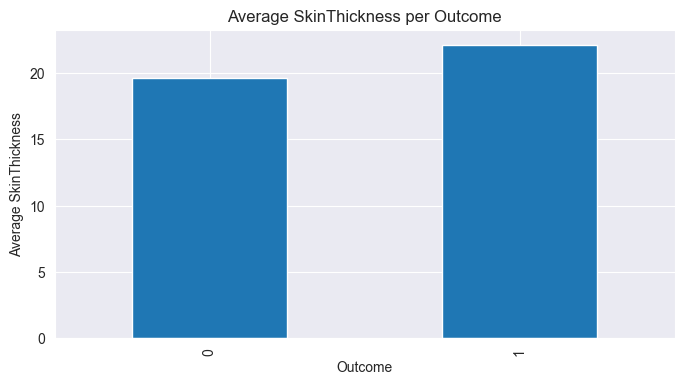

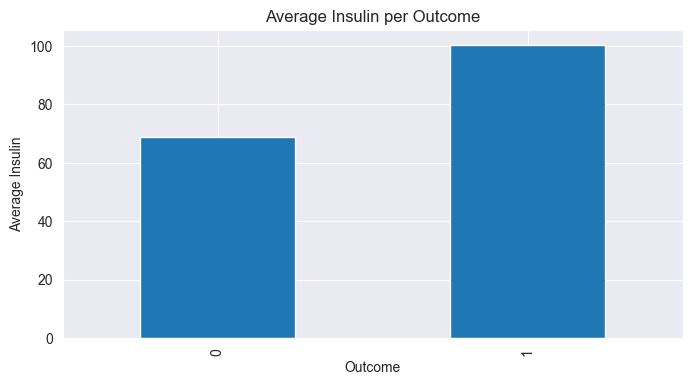

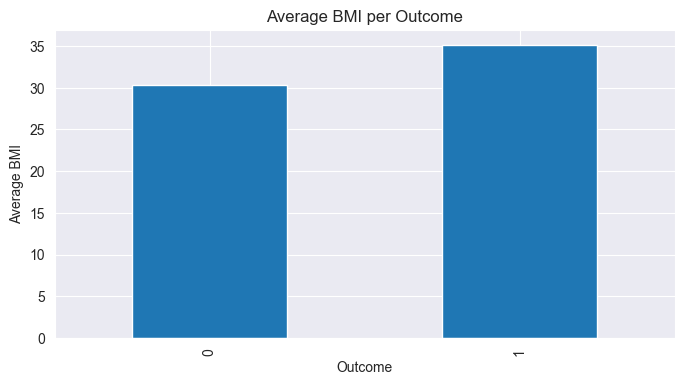

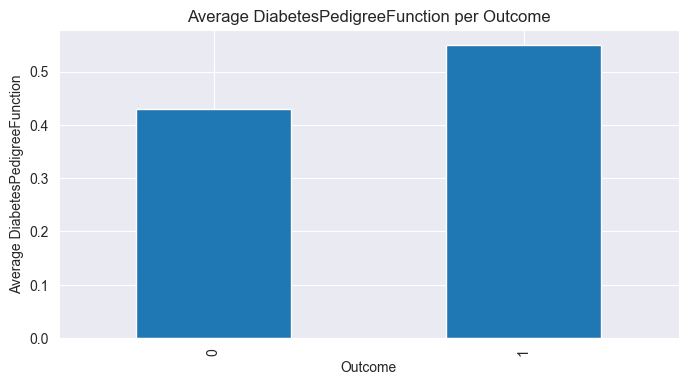

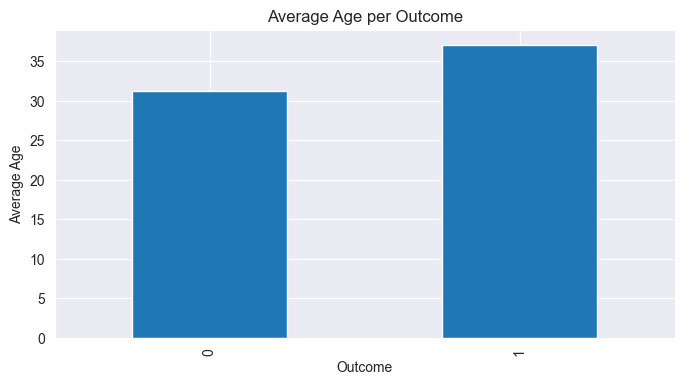

In [26]:
grouped_mean = df.groupby('Outcome').mean()

# Plot a histogram for each feature
for column in grouped_mean.columns:
    plt.figure(figsize=(8, 4))
    grouped_mean[column].plot(kind='bar')
    plt.title(f'Average {column} per Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(f'Average {column}')
    plt.show()

These diagrams show us the difference on average for each outcome between diabetic and non-diabetic people. The levels of glucose and insulin, the BMI and the number of pregnancies are on average much higher with diabetics than non-diabetics. Blood pressure on the other hand is almost similar. We can assume that Glucose, Insulin, BMI and Pregnancies might be some of the most important features for prediction while BloodPressure might not.

### Missing values
Now, we can look for missing values.

In [8]:
# Checking for missing data

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

We can see that there are no missing values in the dataset. 

We can check for abnormal values.

In [9]:
# Checking data ranges and basic summary

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We notice that Glucose, BloodPressure, SkinThickness, Insulin and BMI have minimum values equal to zero. It means that some entries have these features equal to zero, which is not logical so, we are going to replace these zero values by suitable ones without altering the dataset too much.

In [10]:
# Checking 0 value row's count in specific columns

x = df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] == 0
x = x.sum()
print(x)

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Here we cans see that While Glucose BMI and BloodPressure have fewer missing values(0 values), Insulin and SkinThickness have a high missing values. 

### Dealing with missing data

For the columns with fewer missing values (less than 50), we will replace them with the average of the corresponding column.

For the 2 columns having high missing values (Insulin and SkinThickness), we could try 3 things: 

1. remove those rows from the data thereby reducing the dataset 
2. ignore those columns during modelling
3. try to fill the missing values with some logic

In [27]:
# change 0 values to NAN for fewer missing rows
df[["BloodPressure","Glucose","BMI"]] = df[["BloodPressure","Glucose","BMI"]].replace(0, np.NaN)

# fill missing values with mean column values
df.fillna(df.mean(), inplace=True)

# Checking the data
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,20.536458,79.799479,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,15.952218,115.244002,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,23.000000,30.500000,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Here we can observe that the columns Glucose, BloodPressure and BMI no longer have 0 minimum values.

### Experimenting with two datasets

Now let's check the data distribution to decide how to treat missing values for Insulin and SkinThickness.
Before that we need to mark the 0 values for those columns as NULL in order to not skew the data.

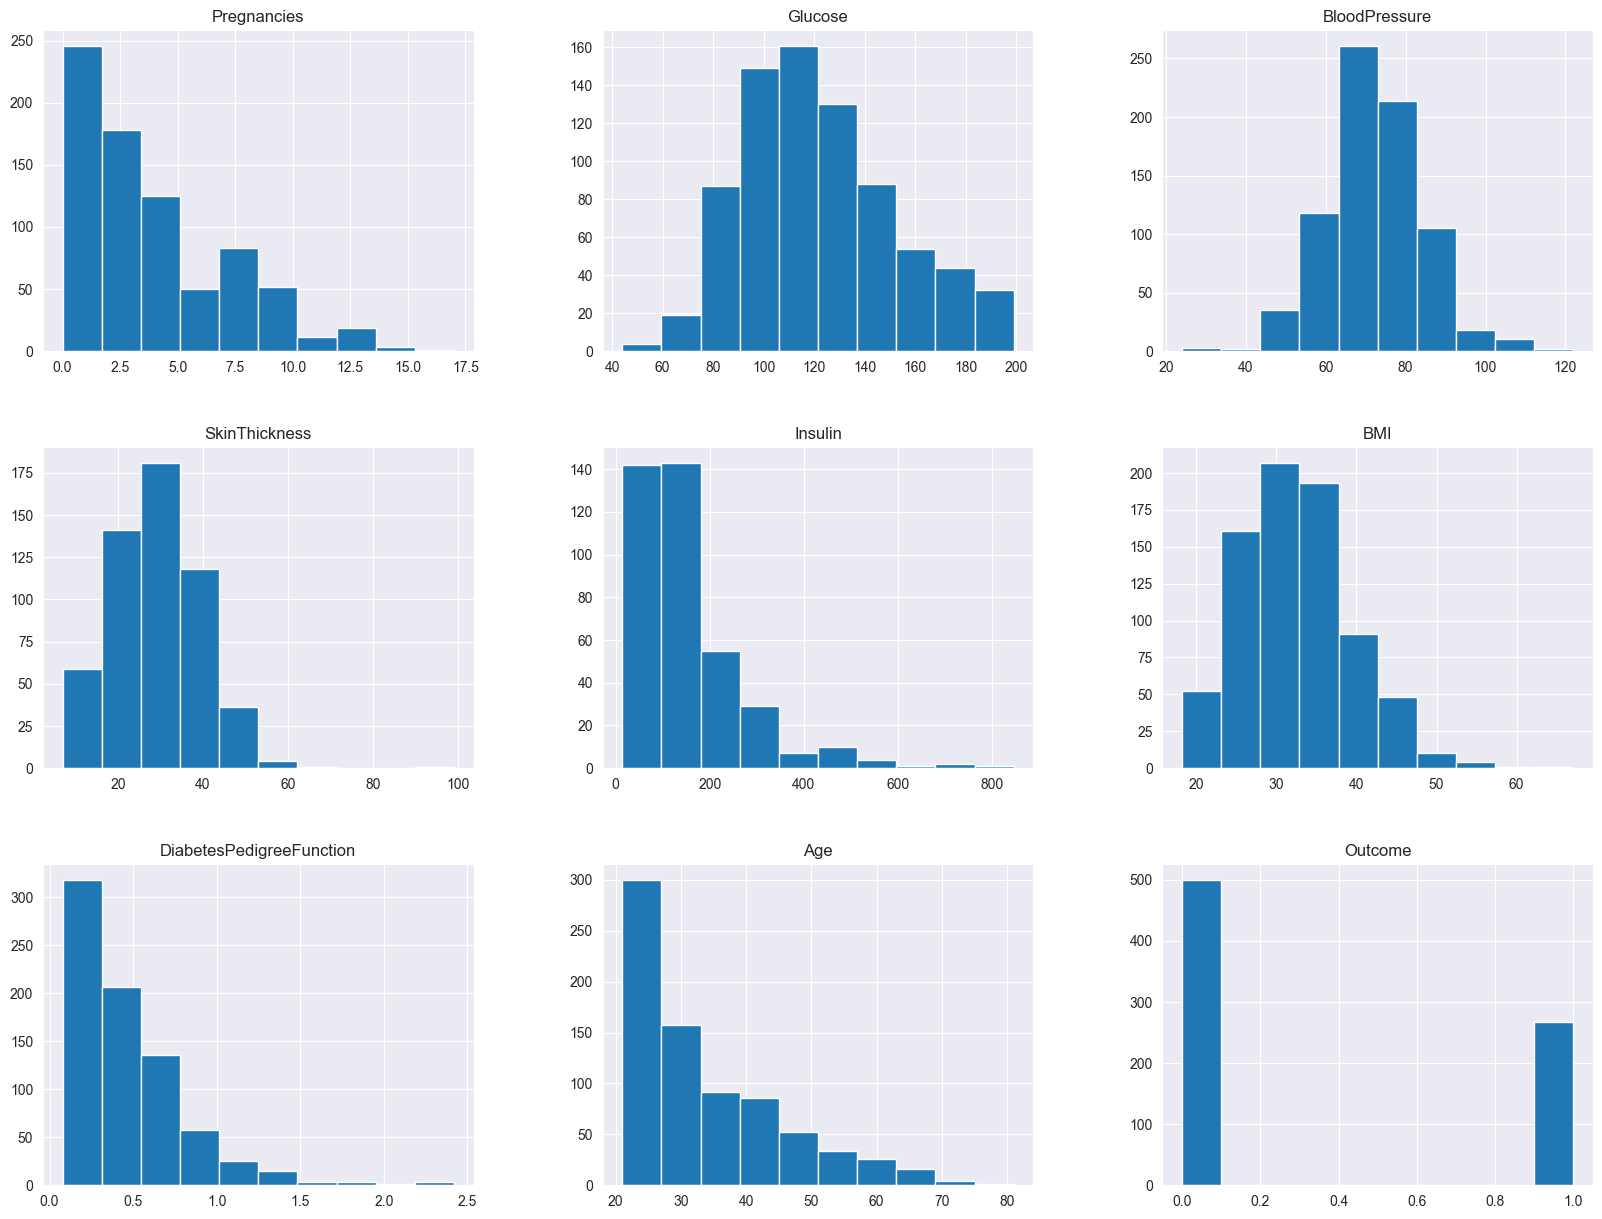

In [28]:
# Mark as Nan
df[["SkinThickness","Insulin"]] = df[["SkinThickness","Insulin"]].replace(0, np.NaN)

fig = df.hist(figsize = (20,15))

The Skin Thickness has a somewhat normal distribution. For this feature, we will replace the missing values with the median.  

However, features like Diabetes Pedigree Function, Insulin, Age, and Pregnancies are skewed to the right.

For Insulin, to avoid making the distribution more skewed, we will remove the rows with missing values. However, we could also try filling them with the mean or median and then compare how that affects our model's accuracy.

In [29]:
# Creating a dataframe df1 with Median values of Skin thickness and median values of Insulin
df1 = df.copy()
df1['SkinThickness'].fillna(df1['SkinThickness'].median(), inplace=True)
df1['Insulin'].fillna(df1['Insulin'].median(), inplace=True)

# Creating a dataframe df2 with Median values for Skin Thickness but removing the missing data for Insulin
df2 = df.copy()
df2['SkinThickness'].fillna(df2['SkinThickness'].median(), inplace=True)
df2.dropna(inplace=True)

C:\Users\naxel\AppData\Local\Temp\ipykernel_20088\2861542888.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['SkinThickness'].fillna(df1['SkinThickness'].median(), inplace=True)
C:\Users\naxel\AppData\Local\Temp\ipykernel_20088\2861542888.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [6]:
# Checking for Null Values in df1

df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 54.1 KB


In [7]:
# Checking for Null Values in df2

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 54.1 KB


### Object correlations

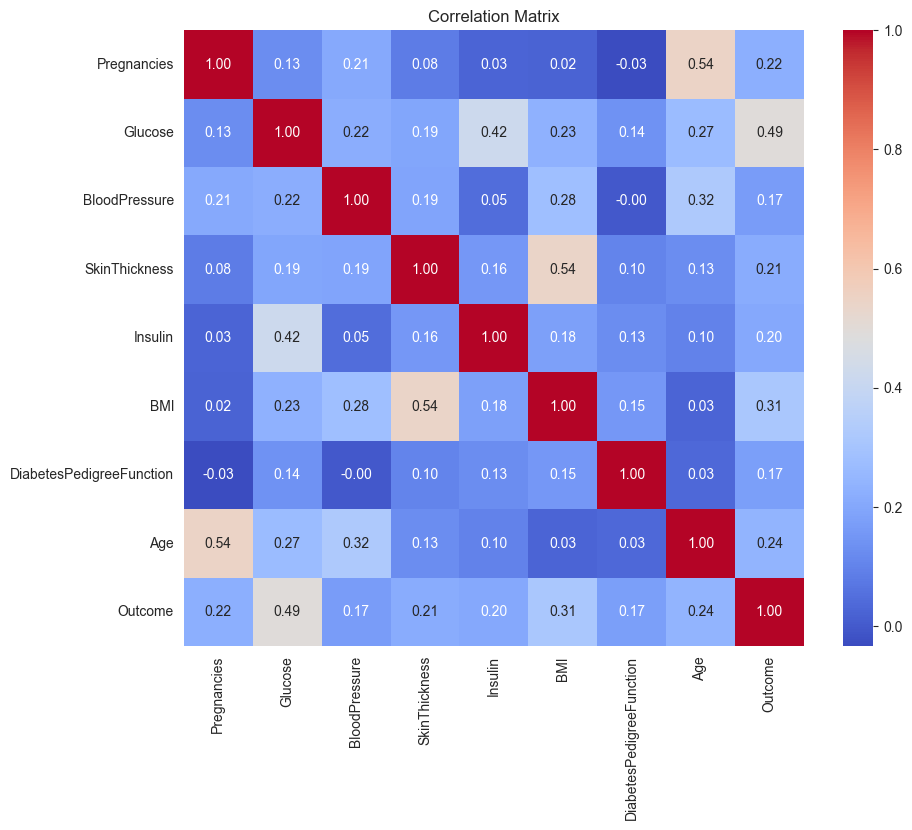

In [16]:
correlation_matrix1 = df1.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

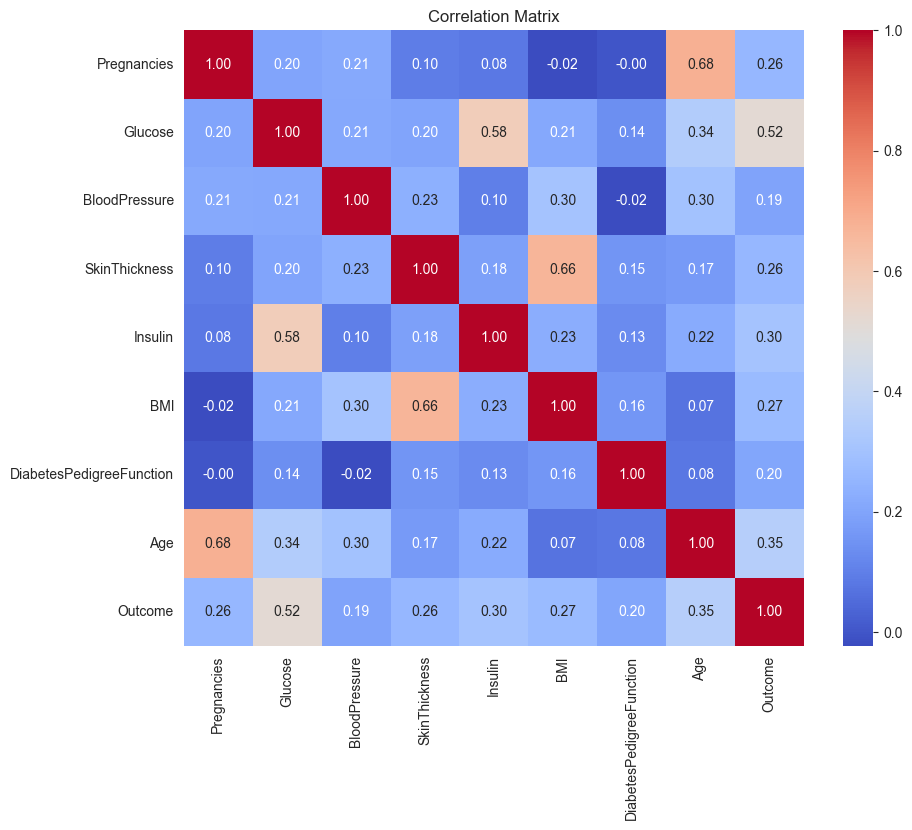

In [17]:
correlation_matrix2 = df2.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

We can observe that:

- There is a moderate correlation between Glucose and Insulin, with values of 0.42 and 0.58.
- Body Mass Index and Skin Thickness also have a moderate correlation, ranging between 0.54 and 0.66.
- Pregnancies and Age are also correlated, with values of 0.54 and 0.68, which is logically expected.

Another key observation is that Glucose has a significant impact on predicting the diabetes outcome, indicating its high importance as a feature in the model.

**Train / Test Split with preserving outcome ratio using Stratify**

In [30]:
train1,test1= train_test_split(df1, test_size=0.25, random_state=0, stratify=df1['Outcome']) # stratify the outcome

train1_X=train1[train1.columns[:8]]
test1_X=test1[test1.columns[:8]]
train1_Y=train1['Outcome']
test1_Y=test1['Outcome']

#### Decision tree

In [32]:
decision_tree_1 = DecisionTreeClassifier(random_state=0)
decision_tree_1.fit(train1_X, train1_Y)
decision_tree_1_pred = decision_tree_1.predict(test1_X)

#Result
print('The accuracy score for decision tree with df1 is:\n', accuracy_score(y_true=test1_Y, y_pred=decision_tree_1_pred))

The accuracy score for decision tree with df1 is:
 0.71875


Let's tune the hyperparameters to get the best performance using grid search.

In [51]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 10, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the DecisionTreeClassifier
decision_tree_1 = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree_1, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(train1_X, train1_Y)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
decision_tree_1_pred = best_model.predict(test1_X)

# Evaluate the model
accuracy_decision_tree1 = accuracy_score(y_true=test1_Y, y_pred=decision_tree_1_pred)
print(f'Accuracy: {accuracy_decision_tree1:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test1_Y, y_pred=decision_tree_1_pred))
report_decision_tree1 =  classification_report(y_true=test1_Y, y_pred=decision_tree_1_pred, output_dict=True)
print("Classification Report:\n", report_decision_tree1)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.73
Confusion Matrix:
 [[99 26]
 [26 41]]
Classification Report:
 {'0': {'precision': 0.792, 'recall': 0.792, 'f1-score': 0.792, 'support': 125.0}, '1': {'precision': 0.6119402985074627, 'recall': 0.6119402985074627, 'f1-score': 0.6119402985074627, 'support': 67.0}, 'accuracy': 0.7291666666666666, 'macro avg': {'precision': 0.7019701492537314, 'recall': 0.7019701492537314, 'f1-score': 0.7019701492537314, 'support': 192.0}, 'weighted avg': {'precision': 0.7291666666666666, 'recall': 0.7291666666666666, 'f1-score': 0.7291666666666666, 'support': 192.0}}


The best accuracy we could get with a decision tree on df1 is 73%

#### Neural network

Now let's try with a neural network. 
Given the relatively small size of the dataset, we don't need a very deep or complex network. A simple feedforward neural network (multilayer perceptron, MLP) should work well for this classification task. Here is the structure of our neural network:  

* **Input Layer**: The input layer size matches the number of features, so **8**, excluding the target column "Outcome".
* **Hidden Layers**:  
    * **Layer 1**: Dense layer with 32 neurons, ReLU activation
    * **Layer 2**: Dense layer with 16 neurons, ReLU activation 
* **Output Layer**: 
    * One neuron in the output layer since this is a binary classification problem
    * Activation function: Sigmoid activation function in the output layer to output a probability between 0 and 1
    * Summary : Dense layer with 1 neuron, Sigmoid activation

In [34]:
# Scale the features 

scaler = StandardScaler()
train1_X_scaled = scaler.fit_transform(train1_X)
test1_X_scaled = scaler.transform(test1_X)

train1_X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
432,1,80.0,74.000000,11.0,60.0,30.000000,0.527,22
453,2,119.0,72.405184,29.0,125.0,19.600000,0.832,72
706,10,115.0,72.405184,29.0,125.0,32.457464,0.261,30
606,1,181.0,78.000000,42.0,293.0,40.000000,1.258,22
118,4,97.0,60.000000,23.0,125.0,28.200000,0.443,22
...,...,...,...,...,...,...,...,...
628,5,128.0,80.000000,29.0,125.0,34.600000,0.144,45
456,1,135.0,54.000000,29.0,125.0,26.700000,0.687,62
398,3,82.0,70.000000,29.0,125.0,21.100000,0.389,25
378,4,156.0,75.000000,29.0,125.0,48.300000,0.238,32


In [36]:
# Define the Neural Network
model = Sequential()

# Layers (input_dim is 8, the number of features in the dataset)
model.add(Dense(32, input_dim=train1_X_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train1_X_scaled, train1_Y, epochs=50, batch_size=10, verbose=1)

# Make predictions on the test set
pred = (model.predict(test1_X_scaled) > 0.5).astype("int32")    # mapping probabilities to either 0 or 1

# Evaluate the model
accuracy = accuracy_score(y_true=test1_Y, y_pred=pred)
print(f'Accuracy: {accuracy:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test1_Y, y_pred=pred))
print("Classification Report:\n", classification_report(y_true=test1_Y, y_pred=pred))

Epoch 1/50


C:\Users\naxel\PycharmProjects\DiabetesClassification\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.5825 - loss: 0.6664
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.7330 - loss: 0.5777 
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7795 - loss: 0.4967
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7750 - loss: 0.4721
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.7775 - loss: 0.4413
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7743 - loss: 0.4693 
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.7753 - loss: 0.4380
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7856 - loss: 0.4578
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7552 - loss: 0.4433
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7764 - loss: 0.4314
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.7656 - loss: 0.4515 
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accur

Let's tune the hyperparameters for best performance using random search.
We will tune :

* Number of neurons a hidden layer (32 to 512). The output layer always has a single neuron since this is a binary classification problem
* Learning Rate: Step size for the optimizer (from 1×10−4 to 1×10−2)
* Number of dense layers (1 to 5). The hidden layers always have a ReLU activation and the output layer, a sigmoid activation as we want to output a probability

In [71]:
def build_model(hp):
    _model = Sequential()
    
    # Tune the number of layers
    num_layers = hp.Int('num_layers', 1, 5)  # Tuning between 1 and 5 layers
    
    for i in range(num_layers):
        _model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),  # tune nb of neurons per layer
                         activation='relu'))
    
    _model.add(Dense(1, activation='sigmoid'))
    _model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), # tune learning rate
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
    return _model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='neural_network',
                     project_name='df1')

tuner.search(train1_X_scaled, train1_Y, epochs=50, validation_split=0.2)

best_neural_net_df1 = tuner.get_best_models(num_models=1)[0]

# Make predictions on the test set
pred = (model.predict(test1_X_scaled) > 0.5).astype("int32")    # mapping probabilities to either 0 or 1
# Evaluate the model
accuracy_net1 = accuracy_score(y_true=test1_Y, y_pred=pred)
print(f'Accuracy: {accuracy_net1:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test1_Y, y_pred=pred))
report_net1 = classification_report(y_true=test1_Y, y_pred=pred, output_dict=True)
print("Classification Report:\n", report_net1)

Reloading Tuner from neural_network\df1\tuner0.json
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.79
Confusion Matrix:
 [[105  20]
 [ 21  46]]
Classification Report:
 {'0': {'precision': 0.8333333333333334, 'recall': 0.84, 'f1-score': 0.8366533864541833, 'support': 125.0}, '1': {'precision': 0.696969696969697, 'recall': 0.6865671641791045, 'f1-score': 0.6917293233082706, 'support': 67.0}, 'accuracy': 0.7864583333333334, 'macro avg': {'precision': 0.7651515151515151, 'recall': 0.7632835820895523, 'f1-score': 0.7641913548812269, 'support': 192.0}, 'weighted avg': {'precision': 0.7857481060606061, 'recall': 0.7864583333333334, 'f1-score': 0.7860809269188908, 'support': 192.0}}


C:\Users\naxel\PycharmProjects\DiabetesClassification\venv\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


We managed to reach an accuracy of 79% on the test set. Though, the dataset is quite unbalanced.

#### Logistic regression

In [74]:
logistic_reg1 = LogisticRegression(max_iter=200)
logistic_reg1.fit(train1_X, train1_Y)
logistic_reg1_pred = logistic_reg1.predict(test1_X)

accuracy_reg1 = accuracy_score(y_true=test1_Y, y_pred=logistic_reg1_pred)
print(f'Accuracy: {accuracy_reg1:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test1_Y, y_pred=logistic_reg1_pred))
report_reg1 = classification_report(y_true=test1_Y, y_pred=logistic_reg1_pred, output_dict=True)
print("Classification Report:\n", report_reg1)

Accuracy: 0.76
Confusion Matrix:
 [[110  15]
 [ 32  35]]
Classification Report:
 {'0': {'precision': 0.7746478873239436, 'recall': 0.88, 'f1-score': 0.8239700374531835, 'support': 125.0}, '1': {'precision': 0.7, 'recall': 0.5223880597014925, 'f1-score': 0.5982905982905983, 'support': 67.0}, 'accuracy': 0.7552083333333334, 'macro avg': {'precision': 0.7373239436619718, 'recall': 0.7011940298507462, 'f1-score': 0.7111303178718908, 'support': 192.0}, 'weighted avg': {'precision': 0.7485988849765258, 'recall': 0.7552083333333334, 'f1-score': 0.7452173164954065, 'support': 192.0}}


### Modeling for df2

We first split the data while preserving outcome ratio using Stratify

In [41]:
train2,test2= train_test_split(df2, test_size=0.25, random_state=0, stratify=df2['Outcome']) # stratify the outcome

train2_X=train2[train1.columns[:8]]
test2_X=test2[test2.columns[:8]]
train2_Y=train2['Outcome']
test2_Y=test2['Outcome']

#### Decision tree

In [42]:
decision_tree_2 = DecisionTreeClassifier(random_state=0)
decision_tree_2.fit(train2_X, train2_Y)
decision_tree_2_pred = decision_tree_2.predict(test2_X)

#Result
print('The accuracy score for decision tree with df2 is:\n', accuracy_score(y_true=test2_Y, y_pred=decision_tree_2_pred))

The accuracy score for decision tree with df2 is:
 0.6666666666666666


Let's tune the hyperparameters to get the best performance using grid search.

In [53]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 10, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the DecisionTreeClassifier
decision_tree_2 = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search2 = GridSearchCV(estimator=decision_tree_2, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search2.fit(train2_X, train2_Y)

# Get the best parameters
best_params2 = grid_search2.best_params_
print(f"Best Parameters: {best_params2}")

# Get the best model
best_model2 = grid_search2.best_estimator_

# Make predictions on the test set
decision_tree_2_pred = best_model2.predict(test2_X)

# Evaluate the model
accuracy_decision_tree2 = accuracy_score(y_true=test2_Y, y_pred=decision_tree_2_pred)
print(f'Accuracy: {accuracy_decision_tree2:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test2_Y, y_pred=decision_tree_2_pred))
report_decision_tree2 = classification_report(y_true=test2_Y, y_pred=decision_tree_2_pred, output_dict=True)
print("Classification Report:\n", report_decision_tree2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.78
Confusion Matrix:
 [[50 16]
 [ 6 27]]
Classification Report:
 {'0': {'precision': 0.8928571428571429, 'recall': 0.7575757575757576, 'f1-score': 0.819672131147541, 'support': 66.0}, '1': {'precision': 0.627906976744186, 'recall': 0.8181818181818182, 'f1-score': 0.7105263157894737, 'support': 33.0}, 'accuracy': 0.7777777777777778, 'macro avg': {'precision': 0.7603820598006645, 'recall': 0.7878787878787878, 'f1-score': 0.7650992234685073, 'support': 99.0}, 'weighted avg': {'precision': 0.8045404208194905, 'recall': 0.7777777777777778, 'f1-score': 0.7832901926948519, 'support': 99.0}}


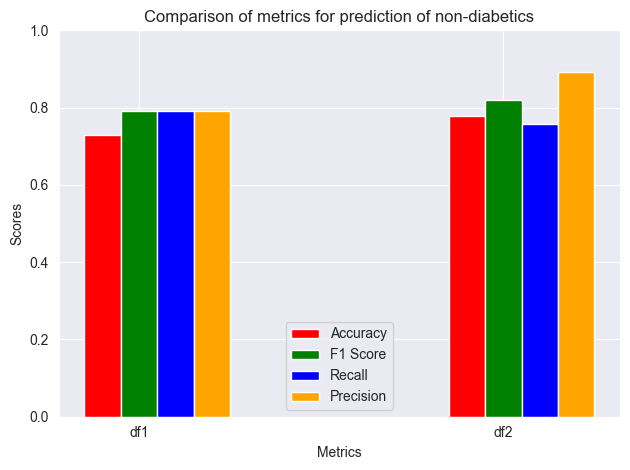

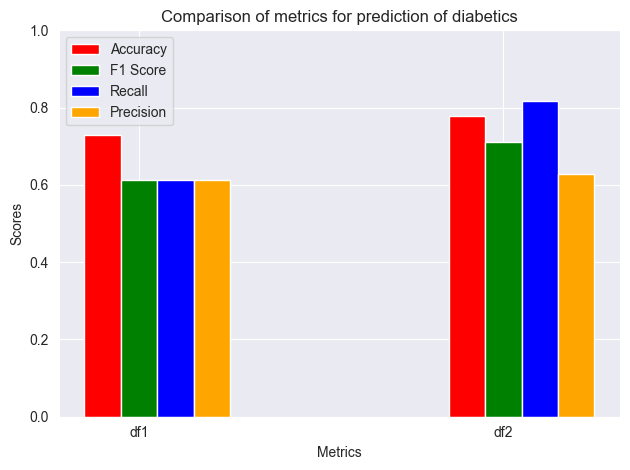

In [62]:
# Set up the plot
def plot_metrics(labels, values, colors, pred_class):
    bar_width = 0.1
    x = np.arange(len(values[0])) 
    
    # Create the histogram
    plt.figure()
    
    # Plot metrics side by side
    for i, metric in enumerate(labels):
        plt.bar(x + i*bar_width, values[i], width=bar_width, label=metric, color=colors[i])
    
    # Customize the plot
    plt.title(f'Comparison of metrics for prediction of {pred_class}')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.xticks(x + bar_width, [f'df{i+1}' for i in range(len(accuracy_values))]) 
    plt.ylim(0, 1)  
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Plotting metrics
accuracy_values = [accuracy_decision_tree1, accuracy_decision_tree2] 
f1_scores0 = [report_decision_tree1["0"]["f1-score"], report_decision_tree2["0"]["f1-score"]] 
recall0 = [report_decision_tree1["0"]["recall"], report_decision_tree2["0"]["recall"]]
precision0 = [report_decision_tree1["0"]["precision"], report_decision_tree2["0"]["precision"]]

f1_scores1 = [report_decision_tree1["1"]["f1-score"], report_decision_tree2["1"]["f1-score"]] 
recall1 = [report_decision_tree1["1"]["recall"], report_decision_tree2["1"]["recall"]]  
precision1 = [report_decision_tree1["1"]["precision"], report_decision_tree2["1"]["precision"]] 

# Combine the data into a single array for plotting
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
values0 = [accuracy_values, f1_scores0, recall0, precision0]
values1 = [accuracy_values, f1_scores1, recall1, precision1]

plot_metrics(labels, values0, ["red", "green", "blue", "orange"], "non-diabetics")
plot_metrics(labels, values1, ["red", "green", "blue", "orange"], "diabetics")


The best accuracy we could get with a decision tree on df2 is 79%, which is greater than df1. Also we have a better precision and recall when predicting non-diabetics.

##### Interpretation 
The distribution of features in df2 after removing zero values may be more favorable for decision tree learning. Decision trees can be sensitive to the distribution of input features, and a more uniform distribution could lead to better splits and, therefore, improved accuracy.   

Also, decision trees are sensitive to the exact values of the data. They create splits based on thresholds that maximize information gain or reduce entropy. If the data contains noise or synthetic values (such as replacing zeros with averages), the tree might overfit to these values, leading to less optimal performance.

Finally, if the zeros in the insulin column are meaningful (e.g., they correspond to a specific health condition or demographic), removing them in df2 could make the model's predictions more applicable and trustworthy in real-world scenarios. The model trained on df2 might generalize better when predicting outcomes for similar patients.

#### Neural network

We will use the same neural network structure as with df1.
Now let's try with a neural network. 
Here is the structure of our neural network:  

* **Input Layer**: The input layer size matches the number of features, so **8**, excluding the target column "Outcome".
* **Hidden Layers**:  
    * **Layer 1**: Dense layer with 32 neurons, ReLU activation
    * **Layer 2**: Dense layer with 16 neurons, ReLU activation 
* **Output Layer**: 
    * One neuron in the output layer since this is a binary classification problem
    * Activation function: Sigmoid activation function in the output layer to output a probability between 0 and 1
    * Summary : Dense layer with 1 neuron, Sigmoid activation

In [63]:
# Scale the features 

scaler2 = StandardScaler()
train2_X_scaled = scaler.fit_transform(train2_X)
test2_X_scaled = scaler.transform(test2_X)

train2_X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
465,0,124.0,56.0,13.0,105.0,21.8,0.452,21
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
656,2,101.0,58.0,35.0,90.0,21.8,0.155,22
297,0,126.0,84.0,29.0,215.0,30.7,0.520,24
554,1,84.0,64.0,23.0,115.0,36.9,0.471,28
...,...,...,...,...,...,...,...,...
85,2,110.0,74.0,29.0,125.0,32.4,0.698,27
659,3,80.0,82.0,31.0,70.0,34.2,1.292,27
152,9,156.0,86.0,28.0,155.0,34.3,1.189,42
682,0,95.0,64.0,39.0,105.0,44.6,0.366,22


In [66]:
# Define the Neural Network
model2 = Sequential()

# Layers (input_dim is 8, the number of features in the dataset)
model2.add(Dense(32, input_dim=train2_X_scaled.shape[1], activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(train2_X_scaled, train2_Y, epochs=50, batch_size=10, verbose=1)

# Make predictions on the test set
pred2 = (model2.predict(test2_X_scaled) > 0.5).astype("int32")    # mapping probabilities to either 0 or 1
# Evaluate the model
accuracy_net2 = accuracy_score(y_true=test2_Y, y_pred=pred2)
print(f'Accuracy: {accuracy_net2:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test2_Y, y_pred=pred2))
report_net2 = classification_report(y_true=test2_Y, y_pred=pred2)
print("Classification Report:\n", report_net2)

Epoch 1/50


C:\Users\naxel\PycharmProjects\DiabetesClassification\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.6687 - loss: 0.6359
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.7713 - loss: 0.5183 
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.7640 - loss: 0.5128
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7655 - loss: 0.4795
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.8046 - loss: 0.4660
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.7955 - loss: 0.4391
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.8009 - loss: 0.4361
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.8537 - loss: 0.3542
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.8176 - loss: 0.3839
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.8507 - loss: 0.3526
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.8469 - loss: 0.3465
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accurac

Let's tune the hyperparameters for best performance using random search.
We will tune :

* Number of neurons a hidden layer (32 to 512). The output layer always has a single neuron since this is a binary classification problem
* Learning Rate: Step size for the optimizer (from 1×10−4 to 1×10−2)
* Number of dense layers (1 to 5). The hidden layers always have a ReLU activation and the output layer, a sigmoid activation as we want to output a probability

In [70]:
tuner2 = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='neural_network',
                     project_name='df2')

tuner2.search(train2_X_scaled, train2_Y, epochs=50, validation_split=0.2)

best_neural_net_df2 = tuner2.get_best_models(num_models=1)[0]

# Make predictions on the test set
pred2 = (best_neural_net_df2.predict(test2_X_scaled) > 0.5).astype("int32")    # mapping probabilities to either 0 or 1
# Evaluate the model
accuracy_net2 = accuracy_score(y_true=test2_Y, y_pred=pred2)
print(f'Accuracy: {accuracy_net2:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test2_Y, y_pred=pred2))
report_net2 = classification_report(y_true=test2_Y, y_pred=pred2, output_dict=True)
print("Classification Report:\n", report_net2)

Reloading Tuner from neural_network\df2\tuner0.json
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.69
Confusion Matrix:
 [[55 11]
 [20 13]]
Classification Report:
 {'0': {'precision': 0.7333333333333333, 'recall': 0.8333333333333334, 'f1-score': 0.7801418439716312, 'support': 66.0}, '1': {'precision': 0.5416666666666666, 'recall': 0.3939393939393939, 'f1-score': 0.45614035087719296, 'support': 33.0}, 'accuracy': 0.6868686868686869, 'macro avg': {'precision': 0.6375, 'recall': 0.6136363636363636, 'f1-score': 0.6181410974244121, 'support': 99.0}, 'weighted avg': {'precision': 0.6694444444444445, 'recall': 0.6868686868686869, 'f1-score': 0.6721413462734851, 'support': 99.0}}


C:\Users\naxel\PycharmProjects\DiabetesClassification\venv\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


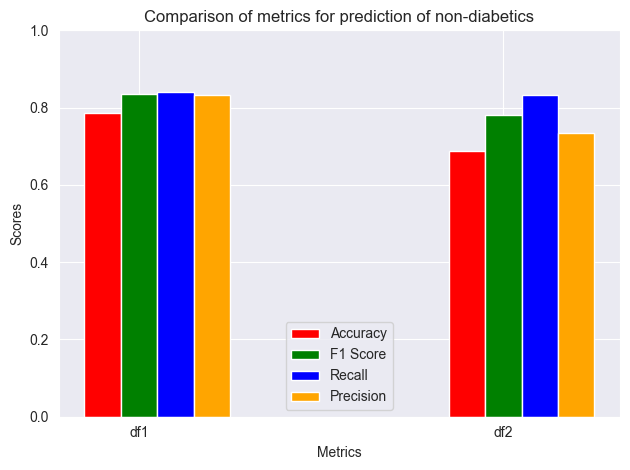

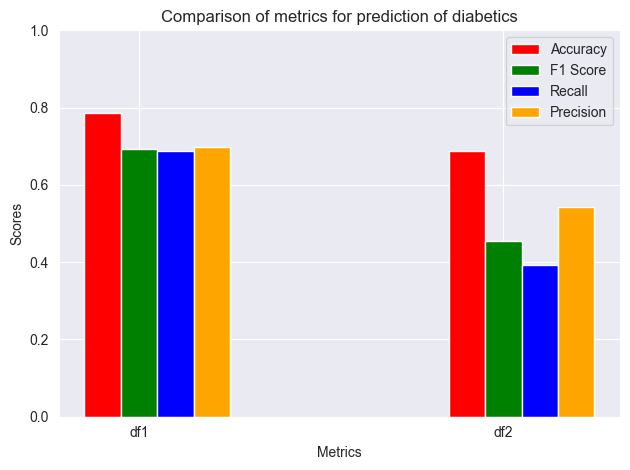

In [72]:
# Plotting metrics
accuracy_values = [accuracy_net1, accuracy_net2]  # Example accuracy values
f1_scores0 = [report_net1["0"]["f1-score"], report_net2["0"]["f1-score"]]
recall0 = [report_net1["0"]["recall"], report_net2["0"]["recall"]] 
precision0 = [report_net1["0"]["precision"], report_net2["0"]["precision"]]

f1_scores1 = [report_net1["1"]["f1-score"], report_net2["1"]["f1-score"]]
recall1 = [report_net1["1"]["recall"], report_net2["1"]["recall"]] 
precision1 = [report_net1["1"]["precision"], report_net2["1"]["precision"]] 

# Combine the data into a single array for plotting
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
values0 = [accuracy_values, f1_scores0, recall0, precision0]
values1 = [accuracy_values, f1_scores1, recall1, precision1]

plot_metrics(labels, values0, ["red", "green", "blue", "orange"], "non-diabetics")
plot_metrics(labels, values1, ["red", "green", "blue", "orange"], "diabetics")

The best accuracy with neural networks on df2 we could reach is 69% on test data, which is lesser than df1 where we reached 79%.

##### Interpretation
In df2, removing rows with zero insulin values reduces the dataset size, which may have deprived the neural network of useful data points. For decision trees, this was beneficial because the noisy rows were gone, allowing for better splits. However, neural networks tend to benefit from more data and may perform worse if the dataset is too small or unbalanced.

Also, neural networks, are less sensitive to specific data points compared to decision trees. Neural networks can better generalize from noisy data due to their ability to learn non-linear relationships and adjust weights dynamically through training. So, the neural network was likely able to better absorb this synthetic data in df1 and still capture meaningful patterns, thanks to its flexibility in fitting non-linear patterns.

#### Logistic regression

In [73]:
logistic_reg2 = LogisticRegression(max_iter=200)
logistic_reg2.fit(train2_X, train2_Y)
logistic_reg2_pred = logistic_reg2.predict(test2_X)

accuracy_reg2 = accuracy_score(y_true=test2_Y, y_pred=logistic_reg2_pred)
print(f'Accuracy: {accuracy_reg2:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test2_Y, y_pred=logistic_reg2_pred))
report_reg2 = classification_report(y_true=test2_Y, y_pred=logistic_reg2_pred, output_dict=True)
print("Classification Report:\n", report_reg2)

Accuracy: 0.76
Confusion Matrix:
 [[58  8]
 [16 17]]
Classification Report:
 {'0': {'precision': 0.7837837837837838, 'recall': 0.8787878787878788, 'f1-score': 0.8285714285714286, 'support': 66.0}, '1': {'precision': 0.68, 'recall': 0.5151515151515151, 'f1-score': 0.5862068965517241, 'support': 33.0}, 'accuracy': 0.7575757575757576, 'macro avg': {'precision': 0.731891891891892, 'recall': 0.696969696969697, 'f1-score': 0.7073891625615764, 'support': 99.0}, 'weighted avg': {'precision': 0.7491891891891891, 'recall': 0.7575757575757576, 'f1-score': 0.7477832512315271, 'support': 99.0}}


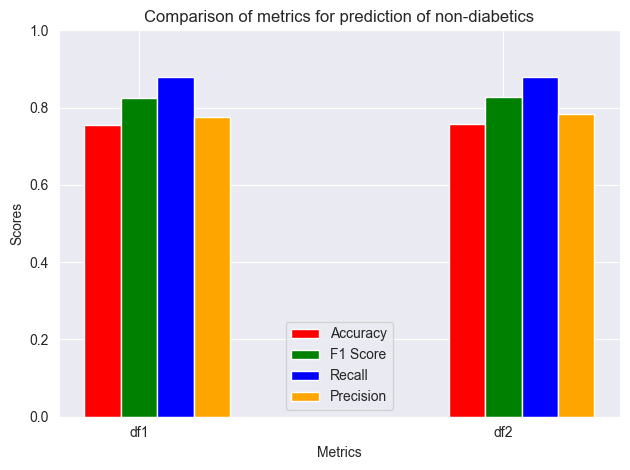

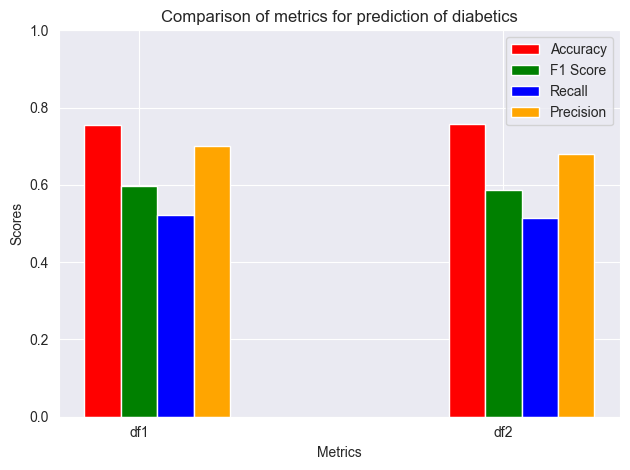

In [75]:
# Plotting metrics
accuracy_values = [accuracy_reg1, accuracy_reg2]  # Example accuracy values
f1_scores0 = [report_reg1["0"]["f1-score"], report_reg2["0"]["f1-score"]]  
recall0 = [report_reg1["0"]["recall"], report_reg2["0"]["recall"]]  
precision0 = [report_reg1["0"]["precision"], report_reg2["0"]["precision"]]  

f1_scores1 = [report_reg1["1"]["f1-score"], report_reg2["1"]["f1-score"]] 
recall1 = [report_reg1["1"]["recall"], report_reg2["1"]["recall"]]  
precision1 = [report_reg1["1"]["precision"], report_reg2["1"]["precision"]]

# Combine the data into a single array for plotting
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
values0 = [accuracy_values, f1_scores0, recall0, precision0]
values1 = [accuracy_values, f1_scores1, recall1, precision1]

plot_metrics(labels, values0, ["red", "green", "blue", "orange"], "non-diabetics")
plot_metrics(labels, values1, ["red", "green", "blue", "orange"], "diabetics")

The accuracy is the same as with df1.   
The precision is greater for non-diabetics but lesser for diabetics (0.01 of difference).   
The recall is the same.  
The f1-score compares in the same way as the precision.  
The macro average is greater than df1 (1 of difference) for precision but exactly the same for the other metrics.   
The weighted average is the same.


##### Interpretation 

Since accuracy is the same for both datasets, the logistic regression model is classifying roughly the same proportion of samples correctly. Accuracy, however, can be misleading as the classes are imbalanced, as it does not distinguish between how well the model performs on different classes (diabetic vs. non-diabetic). This is why looking at precision, recall, and F1-score is crucial. Also, logistic regression, being a linear model, might not be very sensitive to small differences introduced by the different preprocessing techniques.  

In df2, by removing the rows with zero insulin, we might have reduced some noisy or ambiguous data points, allowing the model to be more certain when it predicts non-diabetics.  
The slight decrease in precision for diabetics in df2 (compared to df1) might indicate a trade-off where removing the zero-insulin rows helped with non-diabetic prediction but introduced a slight increase in misclassification for diabetics.  

Since the recall is the same for both datasets, we can assume that the change in preprocessing (imputation vs. row removal) did not significantly affect the model’s ability to find true diabetics in the data, meaning the remaining rows still contained enough information for the model to maintain recall performance.  

The slight decrease in F1-score for diabetics in df2 is directly related to the lower precision for this class. A slight decrease in precision translates to a small drop in the F1-score for diabetics.

Generally, when we imputed average values for zero insulin in df1, it might have introduced some noise, but the model was still able to maintain similar recall and overall accuracy. This suggests that while the imputed averages didn’t hurt the model’s performance significantly, they might not have been as effective for improving precision compared to simply removing rows.

### Modeling with a dataset df3 where zero values for Insulin are ignored (kept to zero)

In [76]:
# Mark as Nan
df[["SkinThickness","Insulin"]] = df[["SkinThickness","Insulin"]].replace(0, np.NaN)

# Creating a dataframe df3 with Median values of Skin thickness but zro insulin is kept tp zero
df3 = df.copy()
df3['SkinThickness'].fillna(df3['SkinThickness'].median(), inplace=True)
df3['Insulin'] = df3['Insulin'].fillna(0)

df3.describe()

C:\Users\naxel\AppData\Local\Temp\ipykernel_20088\4204946062.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df3['SkinThickness'].fillna(df3['SkinThickness'].median(), inplace=True)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.108073,79.799479,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.791221,115.244002,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.000000,30.500000,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [78]:
# Split df3
train3,test3= train_test_split(df3, test_size=0.25, random_state=0, stratify=df3['Outcome']) # stratify the outcome

train3_X=train3[train1.columns[:8]]
test3_X=test3[test3.columns[:8]]
train3_Y=train3['Outcome']
test3_Y=test3['Outcome']

#### Decision tree

In [79]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 10, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the DecisionTreeClassifier
decision_tree_3 = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search3 = GridSearchCV(estimator=decision_tree_3, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search3.fit(train3_X, train3_Y)

# Get the best parameters
best_params3 = grid_search3.best_params_
print(f"Best Parameters: {best_params3}")

# Get the best model
best_model3 = grid_search3.best_estimator_

# Make predictions on the test set
decision_tree_3_pred = best_model3.predict(test3_X)

# Evaluate the model
accuracy_decision_tree3 = accuracy_score(y_true=test3_Y, y_pred=decision_tree_3_pred)
print(f'Accuracy: {accuracy_decision_tree3:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test3_Y, y_pred=decision_tree_3_pred))
report_decision_tree3 = classification_report(y_true=test3_Y, y_pred=decision_tree_3_pred, output_dict=True)
print("Classification Report:\n", report_decision_tree3)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.74
Confusion Matrix:
 [[106  19]
 [ 31  36]]
Classification Report:
 {'0': {'precision': 0.7737226277372263, 'recall': 0.848, 'f1-score': 0.8091603053435115, 'support': 125.0}, '1': {'precision': 0.6545454545454545, 'recall': 0.5373134328358209, 'f1-score': 0.5901639344262295, 'support': 67.0}, 'accuracy': 0.7395833333333334, 'macro avg': {'precision': 0.7141340411413404, 'recall': 0.6926567164179105, 'f1-score': 0.6996621198848705, 'support': 192.0}, 'weighted avg': {'precision': 0.7321347600088476, 'recall': 0.7395833333333334, 'f1-score': 0.7327396967421683, 'support': 192.0}}


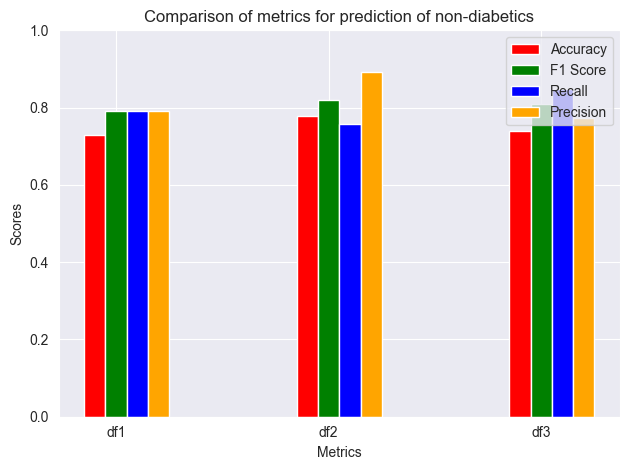

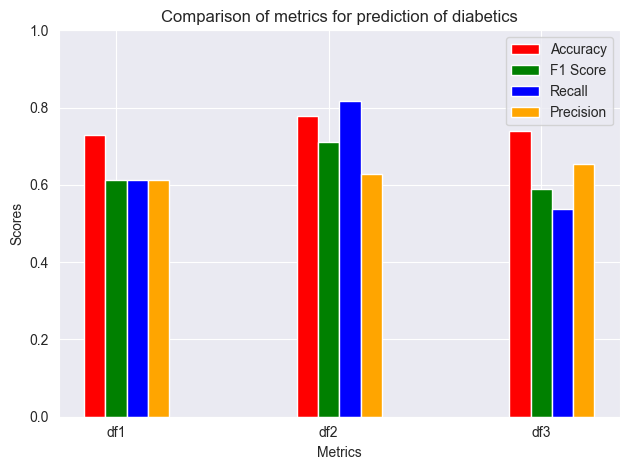

In [82]:
# Plotting metrics
accuracy_values = [accuracy_decision_tree1, accuracy_decision_tree2, accuracy_decision_tree3]  
f1_scores0 = [report_decision_tree1["0"]["f1-score"], report_decision_tree2["0"]["f1-score"], report_decision_tree3["0"]["f1-score"]]  
recall0 = [report_decision_tree1["0"]["recall"], report_decision_tree2["0"]["recall"], report_decision_tree3["0"]["recall"]]  
precision0 = [report_decision_tree1["0"]["precision"], report_decision_tree2["0"]["precision"], report_decision_tree3["0"]["precision"]]  

f1_scores1 = [report_decision_tree1["1"]["f1-score"], report_decision_tree2["1"]["f1-score"], report_decision_tree3["1"]["f1-score"]]  
recall1 = [report_decision_tree1["1"]["recall"], report_decision_tree2["1"]["recall"], report_decision_tree3["1"]["recall"]] 
precision1 = [report_decision_tree1["1"]["precision"], report_decision_tree2["1"]["precision"], report_decision_tree3["1"]["precision"]] 

# Combine the data into a single array for plotting
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
values0 = [accuracy_values, f1_scores0, recall0, precision0]
values1 = [accuracy_values, f1_scores1, recall1, precision1]

plot_metrics(labels, values0, ["red", "green", "blue", "orange"], "non-diabetics")
plot_metrics(labels, values1, ["red", "green", "blue", "orange"], "diabetics")

#### Neural network

In [83]:
# Scale the features 

scaler3 = StandardScaler()
train3_X_scaled = scaler.fit_transform(train3_X)
test3_X_scaled = scaler.transform(test3_X)

train3_X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
432,1,80.0,74.000000,11.0,60.0,30.000000,0.527,22
453,2,119.0,72.405184,29.0,0.0,19.600000,0.832,72
706,10,115.0,72.405184,29.0,0.0,32.457464,0.261,30
606,1,181.0,78.000000,42.0,293.0,40.000000,1.258,22
118,4,97.0,60.000000,23.0,0.0,28.200000,0.443,22
...,...,...,...,...,...,...,...,...
628,5,128.0,80.000000,29.0,0.0,34.600000,0.144,45
456,1,135.0,54.000000,29.0,0.0,26.700000,0.687,62
398,3,82.0,70.000000,29.0,0.0,21.100000,0.389,25
378,4,156.0,75.000000,29.0,0.0,48.300000,0.238,32


In [85]:
# Tuning

tuner3 = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='neural_network',
                     project_name='df3')

tuner3.search(train3_X_scaled, train3_Y, epochs=50, validation_split=0.2)

best_neural_net_df3 = tuner3.get_best_models(num_models=1)[0]

# Make predictions on the test set
pred3 = (best_neural_net_df3.predict(test3_X_scaled) > 0.5).astype("int32")    # mapping probabilities to either 0 or 1
# Evaluate the model
accuracy_net3 = accuracy_score(y_true=test3_Y, y_pred=pred3)
print(f'Accuracy: {accuracy_net3:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test3_Y, y_pred=pred3))
report_net3 = classification_report(y_true=test3_Y, y_pred=pred3, output_dict=True)
print("Classification Report:\n", report_net3)

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.8419540325800577

Best val_accuracy So Far: 0.8419540325800577
Total elapsed time: 00h 00m 59s
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.78
Confusion Matrix:
 [[106  19]
 [ 24  43]]
Classification Report:
 {'0': {'precision': 0.8153846153846154, 'recall': 0.848, 'f1-score': 0.8313725490196079, 'support': 125.0}, '1': {'precision': 0.6935483870967742, 'recall': 0.6417910447761194, 'f1-score': 0.6666666666666666, 'support': 67.0}, 'accuracy': 0.7760416666666666, 'macro avg': {'precision': 0.7544665012406948, 'recall': 0.7448955223880597, 'f1-score': 0.7490196078431373, 'support': 192.0}, 'weighted avg': {'precision': 0.7728688482216709, 'recall': 0.7760416666666666, 'f1-score': 0.7738970588235294, 'support': 192.0}}


C:\Users\naxel\PycharmProjects\DiabetesClassification\venv\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


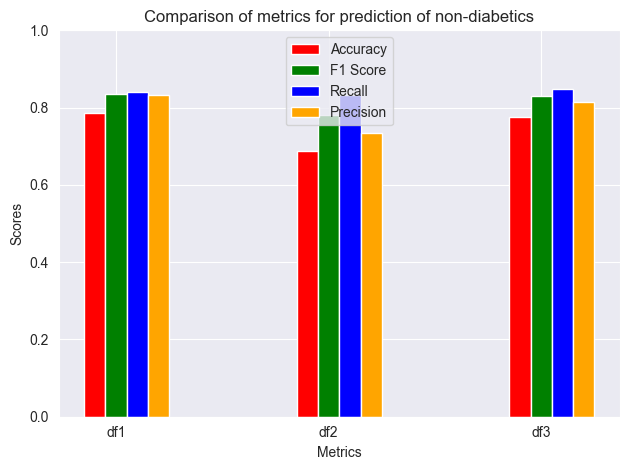

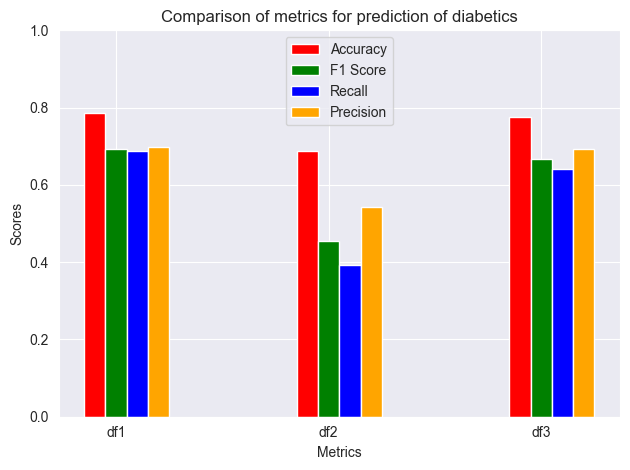

In [90]:
# Plotting metrics
accuracy_values = [accuracy_net1, accuracy_net2, accuracy_net3]  # Example accuracy values
f1_scores0 = [report_net1["0"]["f1-score"], report_net2["0"]["f1-score"], report_net3["0"]["f1-score"]]  
recall0 = [report_net1["0"]["recall"], report_net2["0"]["recall"], report_net3["0"]["recall"]]  
precision0 = [report_net1["0"]["precision"], report_net2["0"]["precision"], report_net3["0"]["precision"]]  

f1_scores1 = [report_net1["1"]["f1-score"], report_net2["1"]["f1-score"], report_net3["1"]["f1-score"]] 
recall1 = [report_net1["1"]["recall"], report_net2["1"]["recall"], report_net3["1"]["recall"]] 
precision1 = [report_net1["1"]["precision"], report_net2["1"]["precision"], report_net3["1"]["precision"]]  

# Combine the data into a single array for plotting
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
values0 = [accuracy_values, f1_scores0, recall0, precision0]
values1 = [accuracy_values, f1_scores1, recall1, precision1]

plot_metrics(labels, values0, ["red", "green", "blue", "orange"], "non-diabetics")
plot_metrics(labels, values1, ["red", "green", "blue", "orange"], "diabetics")

#### Logistic regression

In [89]:
logistic_reg3 = LogisticRegression(max_iter=200)
logistic_reg3.fit(train3_X, train3_Y)
logistic_reg3_pred = logistic_reg3.predict(test3_X)

accuracy_reg3 = accuracy_score(y_true=test3_Y, y_pred=logistic_reg3_pred)
print(f'Accuracy: {accuracy_reg3:.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test3_Y, y_pred=logistic_reg3_pred))
report_reg3 = classification_report(y_true=test3_Y, y_pred=logistic_reg3_pred, output_dict=True)
print("Classification Report:\n", report_reg3)

Accuracy: 0.77
Confusion Matrix:
 [[111  14]
 [ 31  36]]
Classification Report:
 {'0': {'precision': 0.7816901408450704, 'recall': 0.888, 'f1-score': 0.8314606741573034, 'support': 125.0}, '1': {'precision': 0.72, 'recall': 0.5373134328358209, 'f1-score': 0.6153846153846154, 'support': 67.0}, 'accuracy': 0.765625, 'macro avg': {'precision': 0.7508450704225351, 'recall': 0.7126567164179105, 'f1-score': 0.7234226447709594, 'support': 192.0}, 'weighted avg': {'precision': 0.7601628521126761, 'recall': 0.765625, 'f1-score': 0.7560591328147508, 'support': 192.0}}


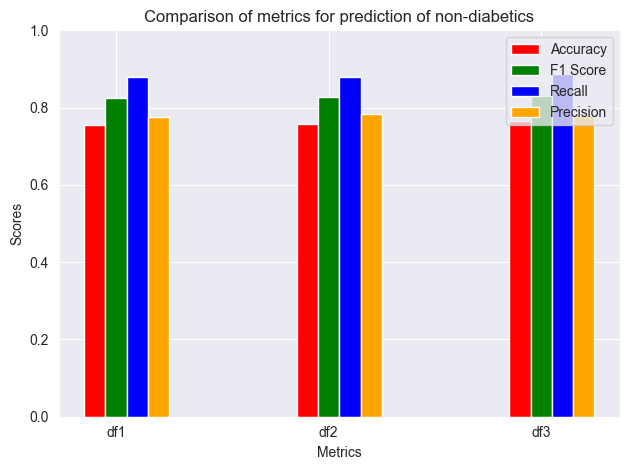

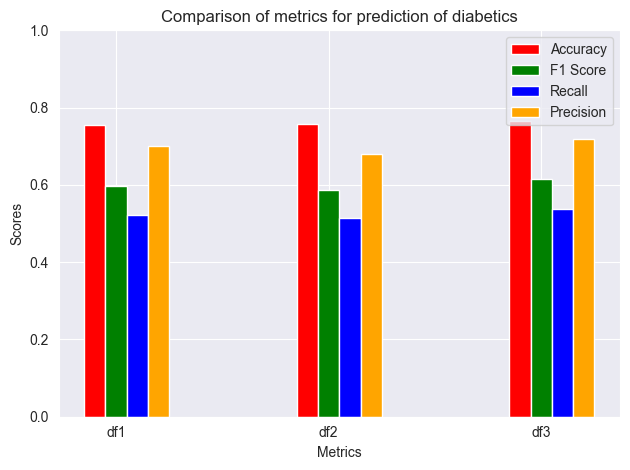

In [91]:
# Plotting metrics
accuracy_values = [accuracy_reg1, accuracy_reg2, accuracy_reg3] 
f1_scores0 = [report_reg1["0"]["f1-score"], report_reg2["0"]["f1-score"],
              report_reg3["0"]["f1-score"]] 
recall0 = [report_reg1["0"]["recall"], report_reg2["0"]["recall"], report_reg3["0"]["recall"]]
precision0 = [report_reg1["0"]["precision"], report_reg2["0"]["precision"],
              report_reg3["0"]["precision"]] 

f1_scores1 = [report_reg1["1"]["f1-score"], report_reg2["1"]["f1-score"],
              report_reg3["1"]["f1-score"]]  
recall1 = [report_reg1["1"]["recall"], report_reg2["1"]["recall"], report_reg3["1"]["recall"]] 
precision1 = [report_reg1["1"]["precision"], report_reg2["1"]["precision"],
              report_reg3["1"]["precision"]]  

# Combine the data into a single array for plotting
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
values0 = [accuracy_values, f1_scores0, recall0, precision0]
values1 = [accuracy_values, f1_scores1, recall1, precision1]

plot_metrics(labels, values0, ["red", "green", "blue", "orange"], "non-diabetics")
plot_metrics(labels, values1, ["red", "green", "blue", "orange"], "diabetics")

It's clear that df2 is better suited for the decision tree while df1 and df3 are better suited for a neural network.
But the overall performance is relatively low. We need to perform feature selection to improve it. As the performances are better with df1 than df3, we will proceed with df1.  
We will also experiment with a RandomForestClassifier from sklearn.

### Selecting the appropriate data for Evaluation



#### Backward selection technique

We start by evaluating the important features. We will remove the one with the least importance and check the metrics.

In [124]:
# Random Forest Model

model = RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(train1_X, train1_Y)
pred = model.predict(test1_X)

# Results
print(f'Accuracy: {accuracy_score(pred, test1_Y):.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test1_Y, y_pred=pred))
print("Classification Report:\n", classification_report(y_true=test1_Y, y_pred=pred))

Accuracy: 0.77
Confusion Matrix:
 [[111  14]
 [ 30  37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83       125
           1       0.73      0.55      0.63        67

    accuracy                           0.77       192
   macro avg       0.76      0.72      0.73       192
weighted avg       0.77      0.77      0.76       192



In [125]:
pd.Series(model.feature_importances_,index= train1_X.columns).sort_values(ascending=False)

Glucose                     0.249622
BMI                         0.154760
Age                         0.143585
DiabetesPedigreeFunction    0.124671
Insulin                     0.085665
BloodPressure               0.083620
Pregnancies                 0.082484
SkinThickness               0.075593
dtype: float64

SkinThickness is the least important.

In [127]:
# Removing SkinThickness

train_selection1, test_selection1 = train_test_split(df1[['Glucose','BMI','Age', 'DiabetesPedigreeFunction', 'Insulin', 'BloodPressure','Pregnancies','Outcome']],test_size=0.25,random_state=0,stratify=df1['Outcome'])

# Training a new model on this new dataset
train_selection1_X = train_selection1[train_selection1.columns[:7]]
test_selection1_X = test_selection1[test_selection1.columns[:7]]
train_selection1_Y = train_selection1['Outcome']
test_selection1_Y = test_selection1['Outcome']

# Random Forest Model
model_selection1 = RandomForestClassifier(n_estimators=100,random_state=0)
model_selection1.fit(train_selection1_X, train_selection1_Y)
pred1 = model_selection1.predict(test_selection1_X)

# Results
print(f'Accuracy: {accuracy_score(pred1, test_selection1_Y):.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test_selection1_Y, y_pred=pred1))
print("Classification Report:\n", classification_report(y_true=test_selection1_Y, y_pred=pred1))

Accuracy: 0.78
Confusion Matrix:
 [[110  15]
 [ 27  40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       125
           1       0.73      0.60      0.66        67

    accuracy                           0.78       192
   macro avg       0.77      0.74      0.75       192
weighted avg       0.78      0.78      0.78       192



The model accuracy improves when we remove the "SkinThickness" feature. Now, we will remove the next least important parameter to see if the performance keeps increasing.

In [128]:
pd.Series(model_selection1.feature_importances_, index= train_selection1_X.columns).sort_values(ascending=False)

Glucose                     0.258335
BMI                         0.178377
Age                         0.155237
DiabetesPedigreeFunction    0.135200
Insulin                     0.095983
BloodPressure               0.093286
Pregnancies                 0.083582
dtype: float64

Pregnancies is the least important.

In [129]:
# Removing SkinThickness and Pregnancies from df1

train_selection2, test_selection2 = train_test_split(df1[['Glucose','BMI','Age', 'DiabetesPedigreeFunction', 'Insulin', 'BloodPressure','Outcome']],test_size=0.25,random_state=0,stratify=df1['Outcome'])# stratify the outcome

# Training a new model on this new dataset
train_selection2_X = train_selection2[train_selection2.columns[:6]]
test_selection2_X = test_selection2[test_selection2.columns[:6]]
train_selection2_Y = train_selection2['Outcome']
test_selection2_Y = test_selection2['Outcome']

# Random Forest Model
model_selection2 = RandomForestClassifier(n_estimators=100,random_state=0)
model_selection2.fit(train_selection2_X, train_selection2_Y)
pred2 = model_selection2.predict(test_selection2_X)

# Results
print(f'Accuracy: {accuracy_score(pred2, test_selection2_Y):.2f}')
print("Confusion Matrix:\n", confusion_matrix(y_true=test_selection2_Y, y_pred=pred2))
print("Classification Report:\n", classification_report(y_true=test_selection2_Y, y_pred=pred2))


Accuracy: 0.77
Confusion Matrix:
 [[107  18]
 [ 26  41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       125
           1       0.69      0.61      0.65        67

    accuracy                           0.77       192
   macro avg       0.75      0.73      0.74       192
weighted avg       0.77      0.77      0.77       192



The performance drops instead of increasing. We stop removing features.  

The Final model has an accuracy of 0.78 (78%).

The confusion matrix above shows that the model correctly interprets 107 true negatives while missing out on 18 and correctly predicts 41 true positives while missing out on 26.

## Conclusion

With our final model we are able to predict diabetes with 78% accuracy. Also, the 2 most important factors while detecting diabetes are:

1. Glucose
2. Body Mass Index